# モデル学習

## Library Import

In [1]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

import datetime as dt

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [47]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../output/intermediate_file/'
model_path = '../output/model/'
oof_path = '../output/oof/'
fi_path = '../output/fi/'

# スクリプトのバージョン指定
fe_ver = 3
training_ver = 4
run_ver = 1 # モデル変更のない特徴量の更新についてはこちらで管理

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [3]:
train_df = pd.read_parquet(f'{intermediate_path}train_df_fe_v{fe_ver}.parquet')

In [4]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [5]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

#### カテゴリ型へ変更

In [8]:
cat_cols = ['building_category', 'land_area_kind',
            'building_land_chimoku', 'land_chisei','land_road_cond', 'access_zone', 'fireproof_x_structure'
]

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [9]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()
train_df[obj_cols] = train_df[obj_cols].astype('category')

## モデルの学習

In [55]:
# --- 東京23区 ---
TOKYO_23 = [
    '千代田区', '中央区', '港区', '新宿区', '文京区', '台東区',
    '墨田区', '江東区', '品川区', '目黒区', '大田区', '世田谷区',
    '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区',
    '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区'
]

# --- 政令指定都市 ---
SEIREI_CITIES = [
    '札幌市', '仙台市', 'さいたま市', '千葉市', '横浜市', '川崎市', '相模原市',
    '新潟市', '静岡市', '浜松市', '名古屋市',
    '京都市', '大阪市', '堺市', '神戸市',
    '岡山市', '広島市', '北九州市', '福岡市', '熊本市'
]

# --- 首都圏（都道府県） ---
CAPITAL_PREFS = ['東京都', '神奈川県', '埼玉県', '千葉県']

# --- 県庁所在地（市名のみ） ---
PREF_CAPITALS = [
    '札幌市','青森市','盛岡市','仙台市','秋田市','山形市','福島市',
    '水戸市','宇都宮市','前橋市','さいたま市','千葉市','新宿区',
    '横浜市','新潟市','富山市','金沢市','福井市','甲府市','長野市',
    '岐阜市','静岡市','名古屋市','津市','大津市','京都市','大阪市',
    '神戸市','奈良市','和歌山市','鳥取市','松江市','岡山市','広島市',
    '山口市','徳島市','高松市','松山市','高知市','福岡市','佐賀市',
    '長崎市','熊本市','大分市','宮崎市','鹿児島市','那覇市'
]

In [56]:
main_city = train_df.index[
    (
        (train_df['Prefecture name'] == '東京都') &
        (train_df['City/town/village name'].isin(TOKYO_23))
    )
    |
    (train_df['City/town/village name'].isin(['大阪市', '名古屋市']))
]

mid_city = train_df.index[
    (
        # 首都圏（23区除外）
        (
            train_df['Prefecture name'].isin(CAPITAL_PREFS)
            &
            ~(
                (train_df['Prefecture name'] == '東京都') &
                (train_df['City/town/village name'].isin(TOKYO_23))
            )
        )
        |
        # 政令指定都市
        (train_df['City/town/village name'].isin(SEIREI_CITIES))
        |
        # 県庁所在地
        (train_df['City/town/village name'].isin(PREF_CAPITALS))
    )
    &
    ~train_df.index.isin(main_city)
]

other = train_df.index[
    ~train_df.index.isin(main_city)
    &
    ~train_df.index.isin(mid_city)
]

In [10]:
house_idx = train_df['building_category'] == 'house'
non_house_idx = ~house_idx

train_df_house = train_df[house_idx]
train_df_all = train_df[non_house_idx]

all_cols = fe_cols.copy()
house_cols = fe_cols.copy()

In [11]:
year_col = 'target_year'

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 100,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

#### 関数

In [12]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))

In [13]:
def _infer_te_source_col(te_col: str) -> str:
    # "xxx_te" -> "xxx"
    return te_col[:-3] if te_col.endswith("_te") else te_col

def fit_target_encoding_map(
    s_cat: pd.Series,
    y: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
) -> tuple[pd.Series, float]:
    """
    1列のカテゴリ s_cat をターゲット y で target encoding するための mapping を作る。
    smoothing: 大きいほど全体平均に寄る（過学習防止）
    """
    s_cat = s_cat.astype("object")
    y = y.astype(float)

    prior = float(y.mean())

    stats = (
        pd.DataFrame({"cat": s_cat, "y": y})
          .groupby("cat")["y"]
          .agg(["count", "mean"])
    )

    # count が小さいカテゴリは prior に寄せる（smoothing + min_samples_leaf）
    count = stats["count"].astype(float)
    mean  = stats["mean"].astype(float)

    # smoothing 係数（一般的な ridge-like smoothing）
    # enc = (count*mean + smoothing*prior) / (count + smoothing)
    enc = (count * mean + smoothing * prior) / (count + smoothing)

    # さらに min_samples_leaf 未満は prior へ
    if min_samples_leaf > 1:
        enc[count < min_samples_leaf] = prior

    return enc, prior

def apply_target_encoding(
    s_cat: pd.Series,
    mapping: pd.Series,
    prior: float,
) -> pd.Series:
    s_cat = s_cat.astype("object")
    return s_cat.map(mapping).fillna(prior).astype(float)

def recompute_te_for_fold(
    train_df: pd.DataFrame,
    tr_idx: pd.Index,
    apply_idx_list: list[pd.Index],
    te_cols: list[str],
    y_tr: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
    verbose: bool = True,
) -> dict:
    """
    te_cols（例: eki_name1_te）の各列について、
    学習fold（tr_idx）だけでTEをfitし、apply_idx_list の各Indexへ適用する。

    返り値: {te_col: {"src_col":..., "mapping":..., "prior":...}} （必要なら保存用）
    """
    te_meta = {}

    for te_col in te_cols:
        src_col = _infer_te_source_col(te_col)
        if src_col not in train_df.columns:
            if verbose:
                print(f"[WARN] TE元列が見つからないためスキップ: {te_col} (src={src_col})")
            continue

        mapping, prior = fit_target_encoding_map(
            train_df.loc[tr_idx, src_col],
            y_tr.loc[tr_idx],
            smoothing=smoothing,
            min_samples_leaf=min_samples_leaf,
        )

        # 各適用先（train/val/ho など）へ適用
        for idx in apply_idx_list:
            train_df.loc[idx, te_col] = apply_target_encoding(
                train_df.loc[idx, src_col],
                mapping,
                prior
            ).values

        te_meta[te_col] = {"src_col": src_col, "mapping": mapping, "prior": prior}

    return te_meta

In [21]:
def run_cv(
    train_df,
    base_cols,
    target_col,
    year_col,
    base_params,
    n_splits=5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    y = train_df[target_col].astype(float)
    y_log = np.log(y)

    mask_train_cv = train_df[year_col] <= 2021
    mask_holdout  = train_df[year_col] == 2022

    idx_cv = train_df.index[mask_train_cv]
    idx_ho = train_df.index[mask_holdout]

    X_cv_base = train_df.loc[idx_cv, base_cols]
    y_cv_log  = y_log.loc[idx_cv]
    groups_cv = train_df.loc[idx_cv, 'building_id']

    y_ho = y.loc[idx_ho]

    print(f'CV 用データ: {len(idx_cv)} 行')
    print(f'Holdout 用データ (2022): {len(idx_ho)} 行\n')

    # ===== OOF =====
    oof_pred_log      = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_pred_log_base = pd.Series(np.nan, index=train_df.index, dtype=float)

    # ===== HO（fold平均）=====
    ho_pred_log_accum      = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_pred_log_base_accum = pd.Series(0.0, index=idx_ho, dtype=float)

    fi_list_base = []

    # ★ fold ごとの HO base 予測保存（σ算出用）
    ho_base_log_by_fold = []

    gkf = GroupKFold(n_splits=n_splits)
    print('=== GroupKFold CV 開始 ===')

    te_cols_base = [c for c in base_cols if c.endswith('_te')]

    for fold, (tr_idx_local, va_idx_local) in enumerate(
        gkf.split(X_cv_base, y_cv_log, groups_cv), 1
    ):
        tr_idx = idx_cv[tr_idx_local]
        va_idx = idx_cv[va_idx_local]

        # --- fold内TE再計算 ---
        if te_cols_base:
            _ = recompute_te_for_fold(
                train_df=train_df,
                tr_idx=tr_idx,
                apply_idx_list=[tr_idx, va_idx, idx_ho],
                te_cols=te_cols_base,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=(fold == 1),
            )

        # ===== base fit =====
        X_tr_base = train_df.loc[tr_idx, base_cols]
        y_tr_log  = y_log.loc[tr_idx]
        base_model = lgb.LGBMRegressor(**base_params)
        base_model.fit(X_tr_base, y_tr_log)

        # ===== OOF predict（base / low だけ）=====
        X_va_base = train_df.loc[va_idx, base_cols]
        va_base_log = base_model.predict(X_va_base)

        oof_pred_log_base.loc[va_idx] = va_base_log

        # ===== HO predict（保存）=====
        X_ho_base = train_df.loc[idx_ho, base_cols]
        ho_base_log = base_model.predict(X_ho_base)

        ho_base_log_by_fold.append(
            pd.Series(ho_base_log, index=idx_ho)
        )

        ho_pred_log_base_accum += ho_base_log / n_splits

        # ===== fold MAPE（base only）=====
        fold_mape = mape(y.loc[va_idx], np.exp(va_base_log))
        print(f'Fold {fold}: val MAPE (base)={fold_mape:.4f}')

        # ===== FI =====
        fi_list_base.append(pd.DataFrame({
            'feature': base_cols,
            'importance': base_model.booster_.feature_importance(importance_type='gain'),
            'fold': fold
        }))

    print('=== CV 完了 ===\n')

    # ===== HO の μ, σ =====
    ho_base_log_stack = pd.concat(ho_base_log_by_fold, axis=1)
    ho_base_mu    = ho_base_log_stack.mean(axis=1)
    ho_base_sigma = ho_base_log_stack.std(axis=1)

    # ==========================================================
    # 最終モデル：HO 年を除いた全データで学習
    # ==========================================================
    print('=== Final model training (exclude holdout year) ===')

    # --- TE を全学習データで再計算（重要） ---
    if te_cols_base:
        _ = recompute_te_for_fold(
            train_df=train_df,
            tr_idx=idx_cv,                  # CV 全体
            apply_idx_list=[idx_cv, idx_ho],
            te_cols=te_cols_base,
            y_tr=y_log,
            smoothing=te_smoothing,
            min_samples_leaf=te_min_samples_leaf,
            verbose=True,
        )

    # --- 最終学習 ---
    X_tr_final = train_df.loc[idx_cv, base_cols]
    y_tr_final = y_log.loc[idx_cv]

    final_model = lgb.LGBMRegressor(**base_params)
    final_model.fit(X_tr_final, y_tr_final)

    # --- HO 予測（最終モデル） ---
    X_ho_final = train_df.loc[idx_ho, base_cols]
    ho_pred_log_final = pd.Series(
        final_model.predict(X_ho_final),
        index=idx_ho,
        name='ho_pred_log_final'
    )

    return (
        y, y_ho,

        # --- OOF（base / low の生予測） ---
        oof_pred_log_base,

        # --- HO（各foldの予測平均/HO以外の全データ学習モデルの予測結果） ---
        ho_pred_log_base_accum, ho_pred_log_final,

        # --- HO 不確実性 ---
        ho_base_mu,
        ho_base_sigma,

        # --- Feature Importance ---
        fi_list_base
    )

#### house以外モデル

In [ ]:
(
    y_all, y_ho_all,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_all_base,

    # --- HO（base / low の生予測） ---
    ho_pred_log_all_base, _,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_all_base
) = run_cv(
    train_df=train_df_all,
    base_cols=all_cols,
    target_col=target_col,
    year_col=year_col,
    base_params=base_params,
)

CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40904
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 383
[LightGBM] [Info] Start training from score 16.904156
Fold 1: val MAPE (base)=0.1432
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_fe

In [17]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_all_base)

y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all_base.loc[oof_mask_valid])

oof_mape_all = mape(y_oof, oof_pred_all)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_all:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_all_base)
ho_mape_base = mape(y_ho_all, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

OOF MAPE (2019–2021, base only): 0.142262
2022 hold-out MAPE (base only): 0.125131


In [18]:
#　v1
# OOF MAPE (2019–2021, base only): 0.142489
# 2022 hold-out MAPE (base only): 0.125418
# HO MAPE: 0.12490483861923649
# low applied rate: 0.032500543983542025

# v2
# OOF MAPE (2019–2021, base only): 0.142422
# 2022 hold-out MAPE (base only): 0.125126
# HO MAPE: 0.1246818258158866
# low applied rate: 0.03166973275572172

# v3
# OOF MAPE (2019–2021, base only): 0.142636
# 2022 hold-out MAPE (base only): 0.125428
# HO MAPE: 0.12499398431965192
# low applied rate: 0.032421419104702

# v4
# OOF MAPE (2019–2021, base only): 0.142581
# 2022 hold-out MAPE (base only): 0.125394
# HO MAPE: 0.1248796598992235
# low applied rate: 0.03234229422586197

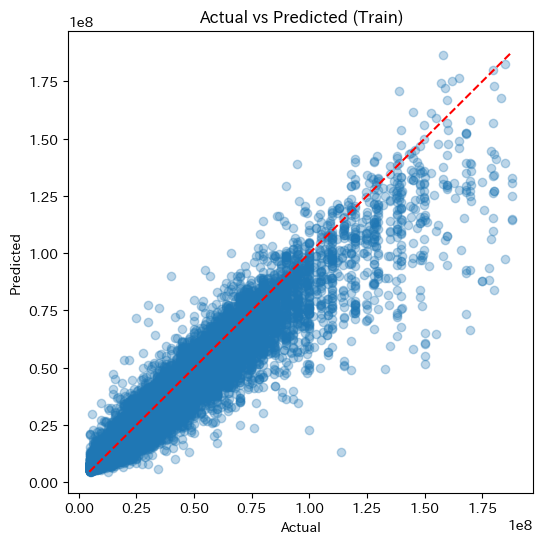

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_all, ho_pred_base, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_all.min(), ho_pred_base.min())
max_val = max(y_ho_all.max(), ho_pred_base.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

#### houseモデル

In [23]:
(
    y_house, y_ho_house,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_house_base,

    # --- HO（base / low の生予測） ---
    ho_pred_log_house_base, _,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_house_base
) = run_cv(
    train_df=train_df_house,
    base_cols=house_cols,
    target_col=target_col,
    year_col=year_col,
    base_params=base_params,
)

CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39512
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 345
[LightGBM] [Info] Start training from score 16.782947
Fold 1: val MAPE (base)=0.1894
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_fea

In [24]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_house_base)

y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house_base.loc[oof_mask_valid])

oof_mape_house = mape(y_oof, oof_pred_house)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_house:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_house_base)
ho_mape_base = mape(y_ho_house, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

OOF MAPE (2019–2021, base only): 0.188894
2022 hold-out MAPE (base only): 0.166319


In [25]:
#　v1
# OOF MAPE (2019–2021, base only): 0.189835
# 2022 hold-out MAPE (base only): 0.166623
# HO MAPE: 0.168341344499982
# low applied rate: 0.027811242406377362

# v2
# OOF MAPE (2019–2021, base only): 0.189837
# 2022 hold-out MAPE (base only): 0.166442
# HO MAPE: 0.16813506264394115
# low applied rate: 0.027734344961935765

# v3
# OOF MAPE (2019–2021, base only): 0.189647
# 2022 hold-out MAPE (base only): 0.166609
# HO MAPE: 0.16813925197000046
# low applied rate: 0.027836874887857892

# v4
# OOF MAPE (2019–2021, base only): 0.189356
# 2022 hold-out MAPE (base only): 0.166325
# HO MAPE: 0.16807249687007628
# low applied rate: 0.028221362110065876

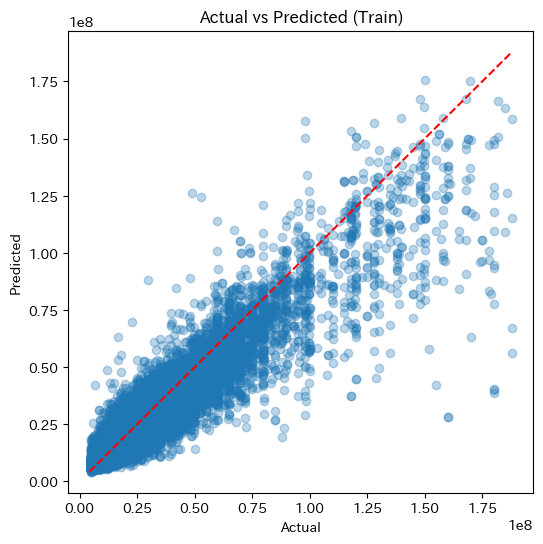

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_house, ho_pred_base, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_house.min(), ho_pred_base.min())
max_val = max(y_ho_house.max(), ho_pred_base.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 特徴量重要度

In [27]:
all_base_fi = (
    pd.concat(fi_list_all_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

house_base_fi = (
    pd.concat(fi_list_house_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

In [28]:
all_base_fi.to_csv(f'{fi_path}feature_importance_all_base_{run_ver}.csv', index=False)
house_base_fi.to_csv(f'{fi_path}feature_importance_house_base_{run_ver}.csv', index=False)

#### 特徴量重要度==0を削除

In [29]:
excluded_fe_all_base = all_base_fi.query('importance == 0')['feature'].tolist()
excluded_fe_house_base = house_base_fi.query('importance == 0')['feature'].tolist()

print(f'[ALL Base] Removed {len(excluded_fe_all_base)} features')
print(f'[HOUSEBase] Removed {len(excluded_fe_house_base)} features')

all_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_base]
house_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_base]

[ALL Base] Removed 65 features
[HOUSEBase] Removed 89 features


#### house以外モデル

In [30]:
(
    y_all, y_ho_all,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_all_base,

    # --- HO（base / low の生予測） ---
    _, ho_pred_all_final,

    # --- HO 不確実性 ---
    ho_base_mu_all, ho_base_sigma_all,

    # --- Feature Importance ---
    fi_list_all_base
) = run_cv(
    train_df=train_df_all,
    base_cols=all_base_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    base_params=base_params,
)

CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40764
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 351
[LightGBM] [Info] Start training from score 16.904156
Fold 1: val MAPE (base)=0.1434
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_fe

In [31]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_all_base)

y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all_base.loc[oof_mask_valid])

oof_mape_all = mape(y_oof, oof_pred_all)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_all:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_all = np.exp(ho_pred_all_final)
ho_mape_base = mape(y_ho_all, ho_pred_all)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

OOF MAPE (2019–2021, base only): 0.142557
2022 hold-out MAPE (base only): 0.125726


#### houseモデル

In [32]:
(
    y_house, y_ho_house,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_house_base,

    # --- HO（base / low の生予測） ---
    _, ho_pred_house_final,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_house_base
) = run_cv(
    train_df=train_df_house,
    base_cols=house_base_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    base_params=base_params,
)

CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39476
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 327
[LightGBM] [Info] Start training from score 16.782947
Fold 1: val MAPE (base)=0.1896
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_fea

In [33]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_house_base)

y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house_base.loc[oof_mask_valid])

oof_mape_house = mape(y_oof, oof_pred_house)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_house:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_house = np.exp(ho_pred_house_final)
ho_mape_base = mape(y_ho_house, ho_pred_house)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

OOF MAPE (2019–2021, base only): 0.188950
2022 hold-out MAPE (base only): 0.166156


#### 学習データの予測結果出力

In [34]:
# ============================================================
# 1) 予測結果を格納する DataFrame
# ============================================================
train_result_df_all = train_df_all[fe_cols + [target_col]].copy()
train_result_df_house = train_df_house[fe_cols + [target_col]].copy()

train_result_df_all['oof_pred'] = np.nan
train_result_df_all['ho_pred'] = np.nan
train_result_df_house['oof_pred'] = np.nan
train_result_df_house['ho_pred'] = np.nan

# --- HO のマスク（2022年） ---
mask_ho_all = train_result_df_all['target_ym'].astype(str).str.startswith('2022')
mask_ho_house = train_result_df_house['target_ym'].astype(str).str.startswith('2022')

# index が完全一致するのでそのまま代入可
train_result_df_all.loc[~mask_ho_all,     'oof_pred'] = oof_pred_all
train_result_df_all.loc[mask_ho_all,      'ho_pred'] = ho_pred_all
train_result_df_house.loc[~mask_ho_house, 'oof_pred'] = oof_pred_house
train_result_df_house.loc[mask_ho_house,  'ho_pred'] = ho_pred_house

# 保存
train_result_df = pd.concat([train_result_df_all, train_result_df_house], axis=0)
train_result_df.to_csv(f'{oof_path}oof_{today}_{run_ver}.csv', index=False)

## 最終モデル

In [35]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
all_base_cols = all_base_cols_filtered.copy()

house_base_cols = house_base_cols_filtered.copy()

y_all     = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

# building_category で house / 非 house に分割
idx_house      = train_df.index[house_idx]
idx_non_house  = train_df.index[~house_idx]   # house 以外

In [39]:
def train_final_model(
    train_df: pd.DataFrame,
    feature_cols: list[str],
    y_log: pd.Series,
    params: dict[str],
    idx
) -> lgb.LGBMRegressor:
    """
    KFold を回さず、指定した idx（または全行）で 1本の最終モデルを学習して返す。

    Parameters
    ----------
    train_df : pd.DataFrame
        学習用特徴量 DataFrame
    feature_cols : list[str]
        使用する特徴量列
    y_log : pd.Series
        目的変数（log 変換済み等）
    params : dict
        LightGBM のパラメータ
    idx : pd.Index | None
        学習に使う行 index（None の場合は train_df 全行）

    Returns
    -------
    lgb.LGBMRegressor
        学習済みモデル
    """
    if idx is None:
        idx = train_df.index

    X_tr = train_df.loc[idx, feature_cols]
    y_tr = y_log.loc[idx]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_tr, y_tr)

    return model


In [ ]:
all_base_model = train_final_model(
    train_df=train_df,
    feature_cols=all_base_cols_filtered,
    y_log=y_all_log,
    params=base_params,
    idx=idx_non_house,          # ★ house 以外だけで学習
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41476
[LightGBM] [Info] Number of data points in the train set: 210468, number of used features: 351
[LightGBM] [Info] Start training from score 16.926918


In [42]:
house_base_model = train_final_model(
    train_df=train_df,
    feature_cols=house_base_cols_filtered,
    y_log=y_all_log,
    params=base_params,
    idx=idx_house,              # ★ house だけで学習
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41202
[LightGBM] [Info] Number of data points in the train set: 153456, number of used features: 327
[LightGBM] [Info] Start training from score 16.798694


## モデルの出力

In [ ]:
import pickle
all_base_dict = {
    'all_base_model': all_base_model,
    'all_base_cols': all_base_cols
}
house_base_dict = {
    'house_base_model': house_base_model,
    'house_base_cols': house_base_cols
}

with open(f'{model_path}all_base_model_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_base_dict, f)
with open(f'{model_path}house_base_model_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_base_dict, f)